# What words and phrases distinguish two groups of documents?

The word scores method offers a way of computing how likely a word is associated with a group in comparison to another group.

Author: Daniel Low
Using the scattertext package


Paper: Kessler, J. (2017, July). Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. In Proceedings of ACL 2017, System Demonstrations (pp. 85-90).

Tutorials:
- https://github.com/JasonKessler/scattertext
- https://colab.research.google.com/drive/1snxAP8X6EIDi42FugJ_h5U-fBGDCqtyS#scrollTo=Zmo4wLW36Xuq

Parameter descriptions are not well described but package has a lot of great options and visualizations
- https://github.com/JasonKessler/scattertext/blob/master/scattertext/__init__.py


# Install packages of certain versions


In [1]:
# Python packages often only work with other packages of a specific version
# !pip install -q matplotlib==3.6.0 spacy==3.6.1 scattertext==0.1.19 pytextrank==3.2.5 textalloc==0.0.3

# Sometimes you need to restart the runtime for installations to take effect

Jupyter: restart the kernel

Colab: Runtime > Restart runtime

In [2]:
import matplotlib
print(matplotlib.__version__)
assert matplotlib.__version__ == '3.6.0' # check if this is True

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
3.6.0


# Load packages

If running on Google Colab it will prompt you to log in to access your Google Drive

In [3]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas
import scattertext as st
import pytextrank, spacy
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

on_google_drive = False # True if running on Google Colab, False if running locally

if on_google_drive:
  # Mount your Google Drive so you can load and save the data there
    from google.colab import drive # this will open a browser window so you can log in
    drive.mount('/content/drive') # then this will take a few seconds

    # CHANGE TO YOUR PATH
    # you can explore your path with os.listdir('/content/') and keep adding folders to the end
    input_dir = '/content/drive/MyDrive/psy2085/labs/7_scattertext/input/' # absolute path on Google Drive
    output_dir = '/content/drive/MyDrive/psy2085/labs/7_scattertext/output/'

else:
  # You can run this script locally on your pc using Jupyter Lab or Jupyter Notebook, and access files there instead of Google Colab
    input_dir = './../data/' # relative path from where the script is
    output_dir = './../data/output/word_scores/'

os.makedirs(output_dir, exist_ok=True)

/Users/danielmlow/miniconda3/envs/concept_tracker/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S') # to save files with a timestamp, making the filename unique so they don't overwrite each other
ts

'24-01-01T21-15-04'

# Load data and preprocess

This dataset contains posts from 28 subreddits (15 mental health support groups) from 2018-2020. We used this dataset to understand the impact of COVID-19 on mental health support groups from January to April, 2020 and included older timeframes to obtain baseline posts before COVID-19.

It comes with a lot of features extracted.

**Please cite if you use this dataset:**

Low, D. M., Rumker, L., Torous, J., Cecchi, G., Ghosh, S. S., & Talkar, T. (2020). Natural Language Processing Reveals Vulnerable Mental Health Support Groups and Heightened Health Anxiety on Reddit During COVID-19: Observational Study. Journal of medical Internet research, 22(10), e22635.

In [4]:
# From a path on Drive or locally:
import pandas as pd

df = pd.read_csv(input_dir + 'reddit/rmhd_27subreddits_1300posts_train.csv', index_col = 0)  # This is a subselection of the original dataset
# df = pd.read_csv(input_dir + 'ctl/train10_train_concurrent_metadata_messages_preprocessed_23-07-20T02-00-58.csv', index_col = 0)  # This is a subselection of the original dataset





In [5]:
df.shape

(28080, 350)

In [6]:
df.columns

Index(['subreddit', 'author', 'date', 'post', 'automated_readability_index',
       'coleman_liau_index', 'flesch_kincaid_grade_level',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index',
       ...
       'tfidf_wish', 'tfidf_without', 'tfidf_wonder', 'tfidf_work',
       'tfidf_worri', 'tfidf_wors', 'tfidf_would', 'tfidf_wrong',
       'tfidf_x200b', 'tfidf_year'],
      dtype='object', length=350)

In [7]:
df.sample(n=30)

subreddit                author        date  \
21289             ptsd    depressedafplzhelp  2019/07/29   
16007      legaladvice        ViceLikeSeeker  2019/08/20   
18418     mentalhealth              Leharoon  2019/06/16   
17237           lonely  DuncanMacHasPonytail  2019/01/13   
13621             guns             10NJBYTES  2018/11/01   
7131           anxiety          Flyingcat100  2019/07/12   
25182         teaching              oozerfip  2018/11/25   
15364    healthanxiety     throwawaymuslim15  2019/10/02   
3599         addiction        lifenutshell83  2019/06/17   
7422            autism         Calamityamity  2018/12/22   
13887             guns            skorea2131  2019/04/23   
4097         addiction           Coolghost75  2019/05/23   
17595           lonely          AutumnGamerX  2019/04/24   
1289      ForeverAlone           Azincourt66  2019/10/08   
14078             guns       MilaneseStapler  2019/05/29   
4283              adhd            dannydawiz  2019/04/13   
7415            autism             LoveJingo  2019/10/25   
8256            autism               kenjiow  2018/12/29   
15292    healthanxiety          DaisytheCute  2019/07/01   
16315      legaladvice                 aw255  2019/08/09   
16474      legaladvice               guamine  2018/12/09   
7955            autism            surfkaboom  2019/05/06   
23330    socialanxiety        singinggiraffe  2019/08/22   
17438           lonely            use2losing  2019/01/20   
4783              adhd  mentally_veryhealthy  2019/10/23   
25013         teaching   doralaexploradora69  2019/03/06   
19734      mindfulness        lightshiner001  2018/12/30   
19958  personalfinance         Doublecinco55  2019/08/19   
10773       conspiracy            LanaAlexis  2019/05/12   
16355      legaladvice    Throwaway567864333  2019/02/21   

                                                    post  \
21289  Advice needed on a friend who is keep setting ...   
16007  Landlords trying to kick my girlfriend out? So...   
18418  Weird Thoughts I don't know if this is the pla...   
17237  Edgy. Just an edgelord teen with no friends. T...   
13621  80 Percent Handgun Im interested if soemone ca...   
7131   I feel like I'm weird and everyone else thinks...   
25182  Considering teaching I have a B.S. in Accounti...   
15364  Worried about EEE — I live adjacent to a high ...   
3599   Hi! My story of addiction and sobriety Hi! My ...   
7422   Help please! I have been asked to a movie and ...   
13887  Geissele Super Duty LE Has the Super Duty LE a...   
4097   90 day Gaming Detox As of today, I have finall...   
17595  I hate winter and spring break. Summer’s even ...   
1289   People you find attractive vs people you'd lik...   
14078  .450 Bushmaster - Recommend Scope &amp; Ammo? ...   
4283   How do I deal with initial Wellbutrin side eff...   
7415   Newly found autistic Hi. I debated on posting....   
8256   Hello It seems I am very likely a high functio...   
15292  Am I going to get skin cancer? Today I went ou...   
16315  Help me I'm stuck. So I have heard of cases wh...   
16474  Apartment problem So on Friday (12/7), I woke ...   
7955   How does everybody feel about violent criminal...   
23330  What is the cure? I'm suffering so much every ...   
17438  Am I The Only One? What is it about making fri...   
4783   Can someone make me clean my room someone just...   
25013  I'm depressed I'm a depressed, lonely, single ...   
19734  Mindfulness and the “Drive” I have always prid...   
19958  Credit score just went up would it be advisabl...   
10773  UK government is trying to ban crossbows Recen...   
16355  (USA RI) When the only victim of a domestic ab...   

       automated_readability_index  coleman_liau_index  \
21289                     7.198750            6.845577   
16007                     2.807431            4.167599   
18418                     1.818142            3.865930   
17237                    -1.613030           -1.419722   
1

In [9]:
# df['docs_clean'].values

In [8]:
df['subreddit'].value_counts() # We have mental health subreddits and other ones (teaching, conspiracy, ukpolitics, unitedkingdom, guns, etc) which may serve as control groups or be of interest by themselves

subreddit
EDAnonymous          1040
healthanxiety        1040
ukpolitics           1040
teaching             1040
suicidewatch         1040
socialanxiety        1040
schizophrenia        1040
ptsd                 1040
personalfinance      1040
mindfulness          1040
mentalhealth         1040
lonely               1040
legaladvice          1040
guns                 1040
ForeverAlone         1040
divorce              1040
depression           1040
conspiracy           1040
bpd                  1040
bipolarreddit        1040
autism               1040
anxiety              1040
alcoholism           1040
adhd                 1040
addiction            1040
UKPersonalFinance    1040
unitedkingdom        1040
Name: count, dtype: int64

# Create two groups



In [9]:
# create column with category vs other, balanced. 
# choose N for category. Then divide N by amount of other categories. Choose that amount of other categories. 

categories = [
       
       'abuse_physical', 'abuse_sexual', 'bereavement', 
       'depressed', 
        'isolated',  
       'relationship', 'self_harm', 'substance', 'suicide',
       'bully',
       'anxiety_stress',
       'eating_body_image', 
    
    'gender_sexual_identity']

len(categories)

13

In [13]:
[print(n) for n in categories]

abuse_physical
abuse_sexual
bereavement
depressed
isolated
relationship
self_harm
substance
suicide
bully
anxiety_stress
eating_body_image
gender_sexual_identity


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [11]:
pd.DataFrame(categories, columns = ['CTL'])

CTL
0           abuse_physical
1             abuse_sexual
2              bereavement
3                depressed
4                 isolated
5             relationship
6                self_harm
7                substance
8                  suicide
9                    bully
10          anxiety_stress
11       eating_body_image
12  gender_sexual_identity

In [16]:


def tags_clean(tags_sorted):    
    tags = [n.replace('[', '').replace(']', '').replace("'", '').replace('\n', '').split(' ') for n in tags_sorted]
    return tags


tags_sorted = df['tags_sorted'].values


tags = tags_clean(tags_sorted)
tags_unique = np.unique([n for i in tags for n in i])
tags_unique = [n.strip('\n') for n in tags_unique]
tags_unique = np.unique(tags_unique)
tags_unique

array(['', '3rd_party', 'abuse_emotional', 'abuse_physical',
       'abuse_sexual', 'abuse_unspecified', 'anxiety', 'bereavement',
       'bully', 'covid_19', 'depressed', 'domestic_violence', 'eating',
       'election', 'family', 'financial', 'friend', 'gender', 'homeless',
       'homicide', 'immigration', 'isolated', 'medical', 'medication',
       'mental', 'military', 'none', 'other', 'out_of_country',
       'psychiatric_hospitalization', 'racism', 'relationship', 'school',
       'self_harm', 'sexual_assault', 'stress', 'substance', 'suicide',
       'therapist_psychiatrist', 'work'], dtype='<U27')

In [17]:
# work_financial_binary = []
# for t in tags:
#     if 'work' in tags or 'financial' in t:
#         work_financial_binary.append(1)
#     else:
#         work_financial_binary.append(0)
        
# df['work_financial'] = work_financial_binary
# df['work_financial'].value_counts()

In [18]:
subsample_n = 2500


def one_vs_rest_subsample(df, category, subsample_n = 2500):
    
    # df_i  = pd.read_csv(input_dir+f'train10_{category}_train.csv')
    # df_category = df_i[df_i['tags'].str.contains(category)]
    
    # df_category = df[df[category]==1]

    # Or choose one group vs a random selection of other groups, which answers the question how is category_aWatch different than all the other mental groups
    df_category = df[df[category]==1].sample(subsample_n)
    df_not_category = df[df[category]==0].sample(subsample_n) # this will take a random sample. Careful if some of the groups are more prevalent they'll be sample more.
    # other_categories = categories.copy()
    # other_categories.remove(category)
    # for c in other_categories:
    df_i = pd.concat([df_category, df_not_category], ignore_index=True) # combine the two groups
    df_i['Group'] = [category if n==1 else 'other' for n in df_i[category].values]
    return df_i


# df_i = one_vs_rest_subsample(df,category, subsample_n = subsample_n)
# tags_sorted = df_i['tags_sorted'].values
# tags = tags_clean(tags_sorted)


In [155]:

df_i[df_i[text_col_name].str.contains(word, case=True)][text_col_name].shape


(29,)

In [161]:
import re

def return_sample_word_in_docs(df, words, text_col_name = 'post', sample_n = 5):
  '''
  text_col_name: make sure you change depending on your dataset
  '''
  words_to_docs = {}
  words_to_docs_windows = {}
  for word in words:
      if word == 'i':
          word = 'I'
      elif word == 'm':
          word = "I'm"
      # elif word  ==

      # search_for = word # '|'.join(search_for could add specific: ' '+word+' ', ' '+word+'.', ' '+word+'?'
      try: docs_with_word = df[df[text_col_name].str.contains(word, case=False)][text_col_name]
      except: 
          print(word, 'not parsed. returning empty list')
          words_to_docs[word] = []
          words_to_docs[word] = []
          continue
      
      
      if docs_with_word.shape[0]>=sample_n:
          docs_with_word = docs_with_word.sample(n=sample_n)
          
      else:
          print(word, 'does not have 5 samples')
      # assert docs_with_word.shape[0] == sample_n # commenting because we'll include terms without matches
      docs_with_word = docs_with_word.values
      docs_with_word = [n.replace('\n', ' ') for n in docs_with_word]
      words_to_docs[word] = '\n'.join(docs_with_word)

      regex_str = r'(?:\b\S+\s*){,7}\b'+ re.escape(word) +r'\b(?:\s*\S+\s*?){,7}' # window of 7 words before and after


      # from each post, return n words before and after target word.
      # try: docs_with_word_windows = [re.findall(regex_str, doc)[0] for doc in docs_with_word]
      # except:
      #     print(docs_with_word)
      #     break

      docs_with_word_windows = []

      for doc in docs_with_word:
          try:
              found = re.findall(regex_str, doc)[0] # Will take the first one if multiple are found
              docs_with_word_windows.append(found)
          except: pass


      # docs_with_word_windows = [n for i in docs_with_word_windows for n in i] #flatten
      words_to_docs_windows[word] = '\n'.join(docs_with_word_windows)
  return words_to_docs, words_to_docs_windows


In [20]:
sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
sw.sort()
sw = [n.replace("'t", "") for n in sw]

In [21]:
from sklearn.preprocessing import MinMaxScaler



In [159]:
categories

['abuse_physical',
 'abuse_sexual',
 'bereavement',
 'depressed',
 'isolated',
 'relationship',
 'self_harm',
 'substance',
 'suicide',
 'bully',
 'anxiety_stress',
 'eating_body_image',
 'gender_sexual_identity']

In [162]:
%%time 
subsample_n = 2500

top_n_words=40
methods = ['rudder', 'logreg_coefs', 'scaled_f_scores']

for category in ['gender_sexual_identity']:
    print(category)
    df_i = one_vs_rest_subsample(df,category, subsample_n = subsample_n)
    print('dataset size for both groups:', df_i.shape[0])
    
    text_col_name = 'docs_clean'
    category_col_name = 'Group'
    not_category = 'other' # other category
    minimum_term_frequency=5 # we don't want to make conclusions based on terms that occur less than N times. You can increase with larger datasets
    compaction = 2000 # The "compaction" process allows users to eliminate terms which may not be associated with a category using a variety of feature selection methods.  The issue with this is that the terms eliminated during the selection process are not taken into account when scaling term positions.
    remove_these_words = '' # emtpy str to not remove anything: '' OR list of tokens to remove: ['in', 'and', 'but'], don't use [''] but rather '' for no removal
    group_col_name = 'Group' # scattertext needs the catregory column to be called Group I think
    df_i[group_col_name] = df_i[category_col_name].values
    
    # preprocess corpus

    print('parsing docs for scattertext')
    # Unigram corpus. this will take about 25 sec for 2000 reddit posts
    # =======================================
    df_parsed = df_i.assign(
        parse=lambda df_i: df_i[text_col_name].apply(st.whitespace_nlp_with_sentences)
    )

    df_parsed[group_col_name] = df_i[group_col_name].values    
    print('done')
    # This part is fast
    corpus_unigram = st.CorpusFromParsedDocuments(df_parsed, category_col=group_col_name, parsed_col='parse')
    corpus_unigram = corpus_unigram.build()
    corpus_unigram = corpus_unigram.remove_terms(terms = remove_these_words)#, ignore_absences=True)
    corpus_unigram = corpus_unigram.get_unigram_corpus()
    corpus_unigram = corpus_unigram.compact(st.AssociationCompactor(compaction))

    # Warning: this is ont the order of the final plot (probably due to percentile_alphabetical or the exact method for f-score?

    
    term_freq_df = corpus_unigram.get_term_freq_df()
    term_freq_df_all = []
    for method in methods:
        if method == 'rudder':
            term_freq_df[f'{category} score'] = corpus_unigram.get_rudder_scores(category) 
            term_freq_df = term_freq_df.sort_values(f'{category} score')
        elif method == 'logreg_coefs':
            term_freq_df[f'{category} score'] = corpus_unigram.get_logreg_coefs(category) 
            term_freq_df = term_freq_df.sort_values(f'{category} score')[::-1]
        elif method == 'scaled_f_scores':            
            term_freq_df[f'{category} score'] = corpus_unigram.get_scaled_f_scores(category) 
            term_freq_df = term_freq_df.sort_values(f'{category} score')[::-1]
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        term_freq_df[category+' score'] = scaler.fit_transform(term_freq_df[category+' score'].values.reshape(-1, 1))
        if method == 'rudder':
            term_freq_df[category+' score'] = term_freq_df[category+' score']*-1
        term_freq_df['method'] = [method]*term_freq_df.shape[0]
        term_freq_df_all.append(term_freq_df.iloc[:top_n_words])
    term_freq_df_all = pd.concat(term_freq_df_all)
    
    term_freq_df_all = term_freq_df_all.sort_values([category+' score'])[::-1]
    term_freq_df_all = term_freq_df_all.reset_index()
    term_freq_df_all = term_freq_df_all.drop_duplicates(subset = 'term')
    # term_freq_df_all = term_freq_df_all.reset_index(drop=True)
    display(term_freq_df_all)
    term_freq_df_all = term_freq_df_all[~term_freq_df_all.index.isin(sw)]
    # display(term_freq_df_all.iloc[:50])
    
    
    # Get docs per word
    
    
    # ngram = 'word' # {'word', 'phrases'}
    # # name_for_y_label = 'logreg_coefs'
    # axes = 'score' # {'freq', 'score'} # freq: word frequency split by group, one on each axis.
    # filename = f'axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'
    n_documents_per_word = 5
    
    top_words_category = list(term_freq_df_all.sort_values(by=f'{category} score', ascending=False)['term'])
    # top_words_category_score = corpus_unigram.get_scaled_f_scores(category)[:top_n_words]

    # get documents where category is present
    df_i = corpus_unigram.get_df()
    df_category = df_i[df_i[group_col_name]==category]
    
    words_to_docs_category_d, words_to_docs_windows_category_d  = return_sample_word_in_docs(df_category, top_words_category,text_col_name=text_col_name, sample_n = n_documents_per_word)
    word_examples = pd.DataFrame(words_to_docs_windows_category_d, index = ['Examples']).T
    word_examples.index.name='term'
    word_examples = word_examples.reset_index()
    word_examples = word_examples.merge(term_freq_df_all, on ='term')
    
    
    word_examples.to_csv(output_dir+'ctl_'+f'{category}-examples-words_{n_documents_per_word}-{ts}.csv')
    word_examples


gender_sexual_identity
dataset size for both groups: 5000
parsing docs for scattertext
done


term  gender_sexual_identity freq  other freq  \
0         gender                          477           5   
1            non                           86          30   
2          panic                          158         172   
3    transgender                          518           6   
4            gay                         1046          11   
..           ...                          ...         ...   
115      walking                           46          75   
116  overwhelmed                          159         216   
117      forward                           81          55   
118         send                          150         170   
119       defect                            5           0   

     gender_sexual_identity score           method  
0                        1.000000           rudder  
1                        1.000000     logreg_coefs  
2                        1.000000  scaled_f_scores  
3                        0.999877           rudder  
4                        0.998802           rudder  
..                            ...              ...  
115                     -0.353260     logreg_coefs  
116                     -0.355200     logreg_coefs  
117                     -0.364814     logreg_coefs  
118                     -0.374526     logreg_coefs  
119                     -0.381459     logreg_coefs  

[117 rows x 5 columns]

ridiculed does not have 5 samples
poking does not have 5 samples
likelihood does not have 5 samples
didint does not have 5 samples
avoids does not have 5 samples
emoji1f463 does not have 5 samples
contained does not have 5 samples
controversial does not have 5 samples
muck does not have 5 samples
neglectful does not have 5 samples
transness does not have 5 samples
worser does not have 5 samples
mods does not have 5 samples
experimenting does not have 5 samples
CPU times: user 19.2 s, sys: 3.54 s, total: 22.8 s
Wall time: 29.3 s


In [160]:
term_freq_df_all

term  gender_sexual_identity freq  other freq  \
0    internalized                           10           0   
1         genders                           18           0   
2     transgender                          528           1   
3    psychiatrist                           44          73   
4         bullied                          127          94   
..            ...                          ...         ...   
107          hasn                          122         103   
108          busy                          127         162   
111        enough                          541         580   
115         kinda                          451         295   
117        figure                          170         132   

     gender_sexual_identity score           method  
0                        1.000000     logreg_coefs  
1                        1.000000  scaled_f_scores  
2                        1.000000           rudder  
3                        0.992625  scaled_f_scores  
4                        0.981958  scaled_f_scores  
..                            ...              ...  
107                     -0.265320     logreg_coefs  
108                     -0.281328     logreg_coefs  
111                     -0.316724     logreg_coefs  
115                     -0.340785     logreg_coefs  
117                     -0.349825     logreg_coefs  

[97 rows x 5 columns]

# OTHER

In [ ]:
tags_l = [n for i in tags for n in i]
from collections import Counter
counts = Counter(tags_l)
counts_13 = {}
for k,v in counts.items():
    if k in categories:
        counts_13[k] = v

counts_13 = {k: v for k, v in sorted(counts_13.items(), key=lambda item: item[1])}
labels = list(counts_13.keys())
print(type(labels))
plt.bar(x= range(10), height = counts_13.values())
# plt.xticks(
#     ticks = range(10),
#     labels = labels
# )


In [15]:
# Either choose documents from two groups. For instance, SuicideWatch vs. depression.
category = 'suicidewatch'
not_category = 'depression'
suicide_depression = df[df['subreddit'].isin([category, not_category])].reset_index(drop=True)
suicide_depression

subreddit                author        date  \
0       depression  HoodOfWhitesnakesCar  2019/04/29   
1       depression  LifeIsShit_WipeItOut  2019/04/29   
2       depression   EnergizedPsychology  2019/02/06   
3       depression     nefariousbeliever  2019/06/27   
4       depression              Bw1234LK  2019/10/09   
...            ...                   ...         ...   
2075  suicidewatch          AlphaBladeYi  2019/08/27   
2076  suicidewatch        happykillfreak  2019/07/01   
2077  suicidewatch    Shadow_Demon_Gamer  2019/09/16   
2078  suicidewatch            Veesabelle  2019/03/23   
2079  suicidewatch         aliakseizuyeu  2019/09/09   

                                                   post  \
0     Started watching Skins on Netflix and after on...   
1     i want to talk to someone, but who? Really fee...   
2     Research Opportunity (18+) Researchers at West...   
3     I feel so empty. I feel like a husky of a huma...   
4     A bad week I’ve had a shit week. Got into it w...   
...                                                 ...   
2075  I'm tired of self-hatred. It's irrational and ...   
2076  Why it's hard to find a friend I feel jealous ...   
2077  Suicide... I hate this world honestly..... And...   
2078  i don't know. I don't know if this is the righ...   
2079  10 days after I am no longer sad but only afra...   

      automated_readability_index  coleman_liau_index  \
0                        1.287698            3.529920   
1                        2.739399            4.491387   
2                       12.869532           15.319862   
3                       -1.597872           -0.057802   
4                        0.967610            3.296671   
...                           ...                 ...   
2075                    -0.898333            1.154095   
2076                     8.838182            6.908256   
2077                    -0.436085            1.676831   
2078                    -0.454375            1.692749   
2079                     4.686557            5.351743   

      flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
0                       2.642590            92.948012       82.544974   
1                       3.360629            92.018007       75.615385   
2                      10.528607            47.589737       51.947977   
3                       1.884511            98.294000       88.787234   
4                       2.178270            95.178601       84.786164   
...                          ...                  ...             ...   
2075                    2.811111            85.595000      101.777778   
2076                    9.215000            68.180000       61.727273   
2077                    1.908221            96.026269       89.641892   
2078                    1.296667           100.015000       90.458333   
2079                    5.791700            80.671197       69.415755   

      gunning_fog_index  ...  tfidf_wish  tfidf_without  tfidf_wonder  \
0              5.684762  ...         0.0       0.000000           0.0   
1              5.342657  ...         0.0       0.000000           0.0   
2             12.533684  ...         0.0       0.000000           0.0   
3              4.611064  ...         0.0       0.000000           0.0   
4              5.042767  ...         0.0       0.000000           0.0   
...                 ...  ...         ...            ...           ...   
2075           6.844444  ...         0.0       0.000000           0.0   
2076          11.981818  ...         0.0       0.000000           0.0   
2077           4.505105  ...         0.0       0.000000           0.0   
2078           4.866667  ...         0.0       0.000000           0.0   
2079           9.156791  ...         0.0       0.066726           0.0   

      tfidf_work  tfidf_worri  tfidf_wors  tfidf_would  tfidf_wrong  \
0       0.000000     0.000000         0.0     0.000000          0.0   
1       0.000000     0.000000         0.0     

In [16]:
# If that didn't work you can download de preprocessed dataset for suicide vs depression
# suicide_depression = pd.read_csv('https://mair.sites.fas.harvard.edu/datasets/rmhd_27subreddits_1300posts_train.csv', index_col = 0)
# suicide_depression

In [114]:
# Or choose one group vs a random selection of other groups, which answers the question how is SuicideWatch different than all the other mental groups
suicide = df[df['subreddit'].isin(['suicidewatch'])]
other_mental_health = df[df['subreddit'].isin(['EDAnonymous', 'addiction','adhd', 'alcoholism', 'anxiety', 'autism', 'bipolarreddit', 'bpd',
       'depression', 'healthanxiety',
        'lonely', 'mentalhealth',
       'ptsd', 'schizophrenia', 'socialanxiety',
       ])] # did not include non mental health ones.


len_suicide = suicide.shape[0]
other_mental_health = other_mental_health.sample(n=len_suicide) # this will take a random sample. Careful if some of the groups are more prevalent they'll be sample more.



suicide_other = pd.concat([suicide, other_mental_health], ignore_index=True) # combine the two groups
suicide_other['Group'] = ['suicidewatch' if n=='suicidewatch' else 'other' for n in suicide_other['subreddit'].values]
suicide_other

subreddit               author        date  \
0      suicidewatch             lxne-mp4  2019/07/28   
1      suicidewatch            Nuklobsta  2019/02/27   
2      suicidewatch        soccpuppetacc  2019/02/13   
3      suicidewatch  emergencyaccount777  2019/10/14   
4      suicidewatch     InsideStatement2  2019/05/14   
...             ...                  ...         ...   
2075           ptsd      traumaqueenblog  2018/12/06   
2076        anxiety         Rouge_pulsar  2019/07/19   
2077  socialanxiety          opiatelover  2019/08/05   
2078           ptsd     Dandeliondust814  2019/08/31   
2079   mentalhealth           Arthurjeek  2019/07/25   

                                                   post  \
0     I feel like I'm unwanted or not interesting to...   
1     I wrote my suicide note I'm sorry, I'm sorry t...   
2     Paracetamol Overdose Just wondering how much i...   
3     panic attack anyone else feel like they were m...   
4     16 days left : I had second thoughts but the s...   
...                                                 ...   
2075  New Trauma Blog- traumaqueenblog.com I am star...   
2076  Meditation causes Anxiety? When I meditate I t...   
2077  Extreme case of social phobia, schizoid person...   
2078  Question regarding a response that I’m assumin...   
2079  Is it possible to have Asperger’s Syndrome, bu...   

      automated_readability_index  coleman_liau_index  \
0                        1.693265            3.085173   
1                        3.959315            6.597848   
2                        9.417647           13.922204   
3                        2.896571            4.241397   
4                        5.562760            7.289110   
...                           ...                 ...   
2075                     9.788824           10.820402   
2076                     4.300000            7.693530   
2077                     5.814813            7.458101   
2078                     8.457569            7.546996   
2079                    13.495909           11.155764   

      flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
0                       3.445624            91.837245       77.585366   
1                       5.220040            75.957500       75.180556   
2                       7.160294            58.866324       67.823529   
3                       4.502063            85.685000       74.333333   
4                       5.927198            76.570094       68.257951   
...                          ...                  ...             ...   
2075                    9.434118            57.703529       58.411765   
2076                    7.001667            58.222500       82.333333   
2077                    6.857360            70.459295       67.549618   
2078                    8.445172            70.137069       61.775862   
2079                   12.418056            50.113750       53.242424   

      gunning_fog_index  ...  tfidf_without  tfidf_wonder  tfidf_work  \
0              6.384505  ...            0.0      0.000000    0.000000   
1              8.280952  ...            0.0      0.000000    0.000000   
2             12.811765  ...            0.0      0.457331    0.000000   
3              6.476190  ...            0.0      0.000000    0.000000   
4              9.489416  ...            0.0      0.000000    0.074808   
...                 ...  ...            ...           ...         ...   
2075          11.505882  ...            0.0      0.000000    0.000000   
2076          11.000000  ...            0.0      0.000000    0.000000   
2077          10.248614  ...            0.0      0.000000    0.000000   
2078          11.517241  ...            0.0      0.000000    0.000000   
2079          15.556566  ...            0.0      0.000000    0.000000   

      tfidf_worri  tfidf_wors  tfidf_would  tfidf_wrong  tfidf_x200b  \
0             0.0    0.000000      0.00000     0.000000          0.0   
1             0.0    0.000000      0.00000   


# set configuration variables

Variables that change from dataset to dataset or provide options for the later analyses



In [115]:
df = suicide_other.copy() # define DF for the remaining code
text_col_name = 'post'
category_col_name = 'Group'
category = 'suicidewatch'
not_category = 'other' # other category
minimum_term_frequency=3 # we don't want to make conclusions based on terms that occur less than N times. You can increase with larger datasets
compaction = 2000 # The "compaction" process allows users to eliminate terms which may not be associated with a category using a variety of feature selection methods.  The issue with this is that the terms eliminated during the selection process are not taken into account when scaling term positions.
remove_these_words = '' # emtpy str to not remove anything: '' OR list of tokens to remove: ['in', 'and', 'but'], don't use [''] but rather '' for no removal
group_col_name = 'Group' # scattertext needs the catregory column to be called Group I think
df[group_col_name] = df[category_col_name].values


In [116]:
df

subreddit               author        date  \
0      suicidewatch             lxne-mp4  2019/07/28   
1      suicidewatch            Nuklobsta  2019/02/27   
2      suicidewatch        soccpuppetacc  2019/02/13   
3      suicidewatch  emergencyaccount777  2019/10/14   
4      suicidewatch     InsideStatement2  2019/05/14   
...             ...                  ...         ...   
2075           ptsd      traumaqueenblog  2018/12/06   
2076        anxiety         Rouge_pulsar  2019/07/19   
2077  socialanxiety          opiatelover  2019/08/05   
2078           ptsd     Dandeliondust814  2019/08/31   
2079   mentalhealth           Arthurjeek  2019/07/25   

                                                   post  \
0     I feel like I'm unwanted or not interesting to...   
1     I wrote my suicide note I'm sorry, I'm sorry t...   
2     Paracetamol Overdose Just wondering how much i...   
3     panic attack anyone else feel like they were m...   
4     16 days left : I had second thoughts but the s...   
...                                                 ...   
2075  New Trauma Blog- traumaqueenblog.com I am star...   
2076  Meditation causes Anxiety? When I meditate I t...   
2077  Extreme case of social phobia, schizoid person...   
2078  Question regarding a response that I’m assumin...   
2079  Is it possible to have Asperger’s Syndrome, bu...   

      automated_readability_index  coleman_liau_index  \
0                        1.693265            3.085173   
1                        3.959315            6.597848   
2                        9.417647           13.922204   
3                        2.896571            4.241397   
4                        5.562760            7.289110   
...                           ...                 ...   
2075                     9.788824           10.820402   
2076                     4.300000            7.693530   
2077                     5.814813            7.458101   
2078                     8.457569            7.546996   
2079                    13.495909           11.155764   

      flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
0                       3.445624            91.837245       77.585366   
1                       5.220040            75.957500       75.180556   
2                       7.160294            58.866324       67.823529   
3                       4.502063            85.685000       74.333333   
4                       5.927198            76.570094       68.257951   
...                          ...                  ...             ...   
2075                    9.434118            57.703529       58.411765   
2076                    7.001667            58.222500       82.333333   
2077                    6.857360            70.459295       67.549618   
2078                    8.445172            70.137069       61.775862   
2079                   12.418056            50.113750       53.242424   

      gunning_fog_index  ...  tfidf_without  tfidf_wonder  tfidf_work  \
0              6.384505  ...            0.0      0.000000    0.000000   
1              8.280952  ...            0.0      0.000000    0.000000   
2             12.811765  ...            0.0      0.457331    0.000000   
3              6.476190  ...            0.0      0.000000    0.000000   
4              9.489416  ...            0.0      0.000000    0.074808   
...                 ...  ...            ...           ...         ...   
2075          11.505882  ...            0.0      0.000000    0.000000   
2076          11.000000  ...            0.0      0.000000    0.000000   
2077          10.248614  ...            0.0      0.000000    0.000000   
2078          11.517241  ...            0.0      0.000000    0.000000   
2079          15.556566  ...            0.0      0.000000    0.000000   

      tfidf_worri  tfidf_wors  tfidf_would  tfidf_wrong  tfidf_x200b  \
0             0.0    0.000000      0.00000     0.000000          0.0   
1             0.0    0.000000      0.00000   

In [117]:
# Some functions
class LogOddsRatioSmoothedZScorePrior:
  '''
  This is Scattertext implementation for Monroe et al (2008) more info: https://bookdown.org/Maxine/tidy-text-mining/weighted-log-odds-ratio.html
  '''
  def __init__(self, prior, prior_scale):
      self.prior = prior
      self.prior_scale = prior_scale
  def get_scores(self, a, b):
      ap = a + self.prior * self.prior_scale*sum(a)/sum(self.prior.values)
      bp = b + self.prior * self.prior_scale*sum(b)/sum(self.prior.values)
      lor = (np.log(ap/(np.sum(ap) - ap)) - np.log(bp/(np.sum(bp) - bp)))
      lorstd = 1./ap + 1./(np.sum(ap) - ap) + 1./bp + 1./(np.sum(bp) - bp)
      return lor/np.sqrt(lorstd)

  def get_name(self):
      return 'Log-Odds-Ratio w/ Informative Dirichlet Prior Z-Score'



class LogOddsRatioSmoothedZScorePrior:
    def __init__(self, prior, prior_scale):
        self.prior = prior
        self.prior_scale = prior_scale
    def get_scores(self, a, b):
        ap = a + self.prior * self.prior_scale*sum(a)/sum(self.prior.values)
        bp = b + self.prior * self.prior_scale*sum(b)/sum(self.prior.values)
        lor = (np.log(ap/(np.sum(ap) - ap)) - np.log(bp/(np.sum(bp) - bp)))
        lorstd = 1./ap + 1./(np.sum(ap) - ap) + 1./bp + 1./(np.sum(bp) - bp)
        return lor/np.sqrt(lorstd)

    def get_name(self):
        return 'Log-Odds-Ratio w/ Informative Dirichlet Prior Z-Score'


def return_method(method_name):
    '''
    Arguments:
      method_name: str
        one of  {'fscore', 'rank_difference', 'odds_ratio'}.
        'odds_ratio' is Monroe et al (2008) Fighting word method, more standard, but fscore may provide similar and clearer results.

      only applicable if method_name == 'odds_ratio'
        priors:


        odds_ratio_prior_n: int
        only applicable if method_name == 'odds_ratio'

    Returns:
      A scattertext object for that method
    '''
    if method_name == 'fscore':
        return st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf')
    elif method_name == 'rank_difference':
        return RankDifference()
    elif method_name == 'dense_rank':
        return st.Scalers.dense_rank

def return_corpus(ngram):
    if ngram == 'word':
        return corpus_unigram

    elif ngram == 'phrases':
        return corpus_phrases


In [118]:
return_method('fscore') # this function is to save space in the main pipeline below. Just an example of having more concise code.

# Preprocess

In [119]:
df_toy = df.sample(n=20) # if you want to test anything quickly.

In [120]:
%%time
# this will take about 25 sec for 2000 reddit posts

# Unigram corpus
# =======================================
df_parsed = df.assign(
    parse=lambda df: df[text_col_name].apply(st.whitespace_nlp_with_sentences)
)

# This part is fast
corpus_unigram = st.CorpusFromParsedDocuments(df_parsed, category_col=group_col_name, parsed_col='parse')
corpus_unigram = corpus_unigram.build()
corpus_unigram = corpus_unigram.remove_terms(terms = remove_these_words)#, ignore_absences=True)
corpus_unigram = corpus_unigram.get_unigram_corpus()
corpus_unigram = corpus_unigram.compact(st.AssociationCompactor(compaction))

CPU times: user 14.8 s, sys: 301 ms, total: 15.1 s
Wall time: 15.3 s


# Word scores

## Word scores (axes are F-score as a function of term frequency in corpus, color-coded by F-scores)

In [121]:

ts

'23-12-30T09-37-25'

In [122]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
name_for_y_label = 'Scaled F-Score'
axes = 'score' # {'freq', 'score'} # freq: word frequency split by group, one on each axis.
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}_{ts}'

html = st.produce_fightin_words_explorer(
    corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],

    transform=st.Scalers.percentile_alphabetical, # there multiple options for this
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=return_method(score_method),
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

)

open(output_dir+filename+f'_{ts}.html', 'w').write(html)
display(HTML(html))
# just copy it but add return_scatterplot_structure=True to output the structure


# Save as image

Frequency  Range         SD         VC  Juilland's D  \
i              26473   1962  13.992141   1.099371  9.889201e-01   
feel            1739    841   1.543145   1.845740  9.575168e-01   
like            2091    990   1.586139   1.577795  9.631857e-01   
m               3807   1268   2.481188   1.355627  9.699712e-01   
or              1747    860   1.468857   1.748840  9.578221e-01   
...              ...    ...        ...        ...           ...   
creepy             3      1   0.065764  45.596052  0.000000e+00   
warts              3      1   0.065764  45.596052  0.000000e+00   
storyline          3      1   0.065764  45.596052 -2.220446e-16   
twins              3      1   0.065764  45.596052  0.000000e+00   
phlegm             3      1   0.065764  45.596052  0.000000e+00   

           Rosengren's S        DP   DP norm  KL-divergence  
i               0.953751  0.138347  0.138348       0.110366  
feel            0.499332  0.504681  0.504683       1.202097  
like            0.606675  0.415848  0.415850       0.896280  
m               0.678294  0.376341  0.376343       0.723177  
or              0.557352  0.447155  0.447156       1.025326  
...                  ...       ...       ...            ...  
creepy          0.000298  0.999702  0.999705      11.713503  
warts           0.000419  0.999581  0.999584      11.221650  
storyline       0.000819  0.999181  0.999184      10.254071  
twins           0.001092  0.998908  0.998911       9.839034  
phlegm          0.000174  0.999826  0.999829      12.491110  

[1763 rows x 9 columns]

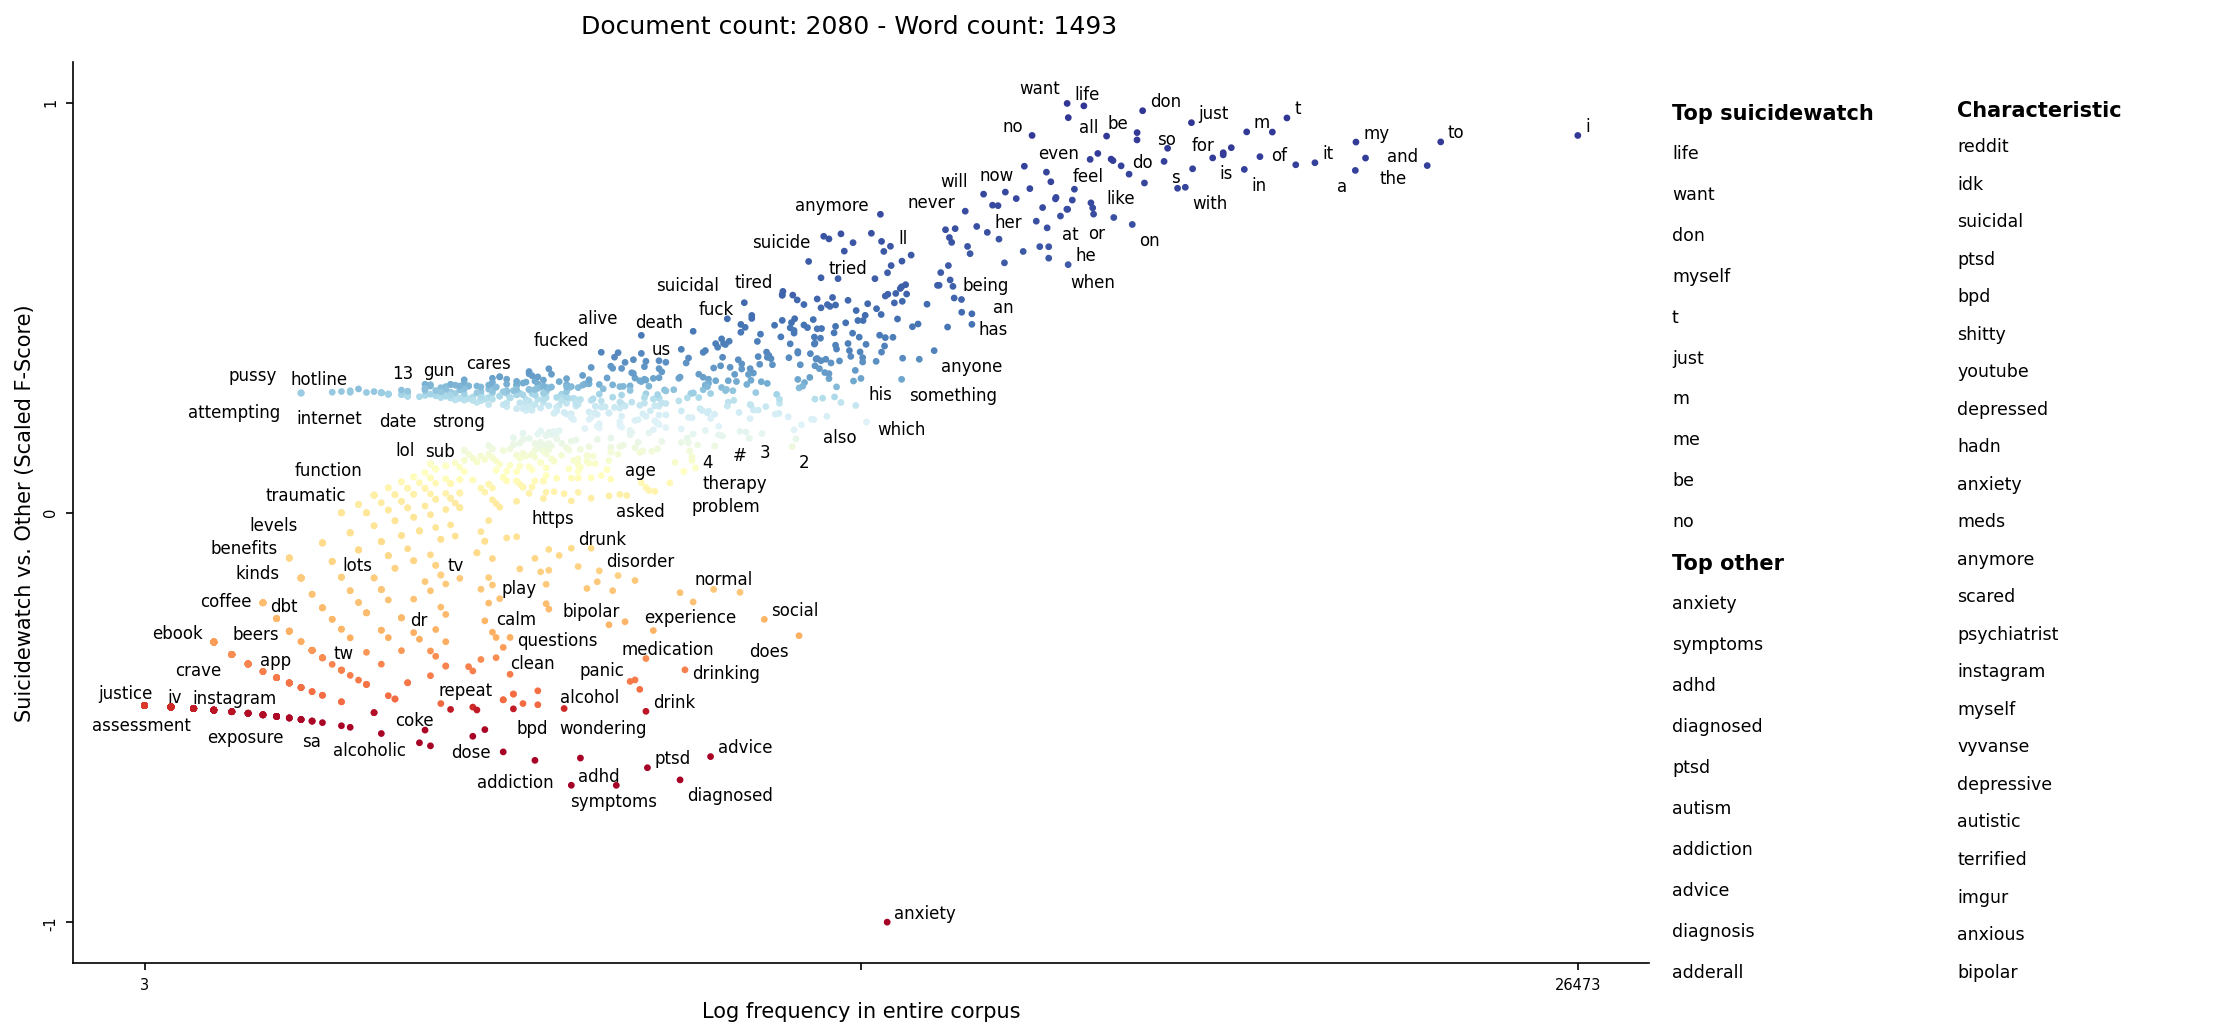

In [123]:
dispersion = st.Dispersion(return_corpus(ngram))
dispersion_df = dispersion.get_df()
display(dispersion_df)

scattertext_structure = st.produce_fightin_words_explorer(
corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)

# Change plotting params add '_' at the beginning:
scattertext_structure._x_label = 'Log frequency in entire corpus'
scattertext_structure._y_label = f'{category.capitalize()} vs. {not_category.capitalize()} ({name_for_y_label})'

# Change plotting params: I think it requires 3 values
log_freq_distr = dispersion_df['Frequency'].values
min_freq = int(np.min(log_freq_distr))
max_freq = int(np.max(log_freq_distr))
scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=150)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
# fig.savefig(output_dir+f'{filename}_{ts}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}_{ts}.png', format='png', dpi = 150)
plt.show()


## Not sure how to save that html as an image on Colab, but this might work on your local machine or Spyder


In [124]:
# !pip install -q html2image

In [125]:
# !pip install -q imgkit

In [126]:


# from html2image import Html2Image
# hti = Html2Image()
# save_as = filename+f'_{ts}.png'

# with open(output_dir+filename+f'_{ts}.html') as f:
#     hti.screenshot(f.read(), save_as=save_as)


# ========================================

# # install chromium, its driver, and selenium
# !apt-get update
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# !pip install selenium
# # set options to be headless, ..
# from selenium import webdriver
# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
# options.add_argument('--no-sandbox')
# options.add_argument('--disable-dev-shm-usage')
# # open it, go to a website, and get results
# wd = webdriver.Chrome('chromedriver',options=options)
# wd.get("https://www.website.com")
# print(wd.page_source)  # results

# ========================================



# List sentences with top words


In [127]:
# !pip install -q nltk
# import sys
# sys.path.insert(1, '../utils/')

# from stop_words import nltk_stop_words 
# sw = nltk_stop_words.get('en')
sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
sw.sort()
sw = [n.replace("'t", "") for n in sw]
sw

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'couldn',
 'd',
 'did',
 'didn',
 'didn',
 'do',
 'does',
 'doesn',
 'doesn',
 'doing',
 'don',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'hadn',
 'has',
 'hasn',
 'hasn',
 'have',
 'haven',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'isn',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'mightn',
 'more',
 'most',
 'mustn',
 'mustn',
 'my',
 'myself',
 'needn',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'sha

In [128]:
category

'suicidewatch'

In [129]:
# Warning: this is ont the order of the final plot (probably due to percentile_alphabetical or the exact method for f-score?
term_freq_df = corpus_unigram.get_term_freq_df()
term_freq_df[f'{category} score'] = corpus_unigram.get_logreg_coefs(category) 
# term_freq_df[f'{category} score'] = corpus_unigram.get_rudder_scores(category) 
# term_freq_df[f'{category} score'] = corpus_unigram.get_scaled_f_scores(category) 
term_freq_df = term_freq_df.sort_values(f'{category} score')[::-1]
display(term_freq_df)
term_freq_df = term_freq_df[~term_freq_df.index.isin(sw)]
term_freq_df.iloc[:50]

suicidewatch freq  other freq  suicidewatch score
term                                                        
suicide                  284          44            4.023664
kill                     287          31            3.725767
die                      297          55            3.037159
suicidal                 164          35            2.918692
life                     922         407            2.729556
...                      ...         ...                 ...
addiction                  7          68           -1.415938
ptsd                      15          97           -1.422836
diagnosed                 20         116           -1.464601
and                     5421        5540           -1.524605
anxiety                   97         365           -2.772444

[1763 rows x 3 columns]

suicidewatch freq  other freq  suicidewatch score
term                                                         
suicide                   284          44            4.023664
kill                      287          31            3.725767
die                       297          55            3.037159
suicidal                  164          35            2.918692
life                      922         407            2.729556
end                       289          89            2.614268
anymore                   350          94            2.092159
fucking                   241          50            1.914826
tried                     225          88            1.820687
live                      272          87            1.818510
pain                      191          74            1.705250
tired                     191          59            1.684408
nothing                   314         107            1.675569
killing                    77           8            1.588085
death                     117          30            1.587482
shit                      187          62            1.475799
family                    310         137            1.445376
alive                     103           5            1.444488
dead                       79          15            1.415827
would                     503         383            1.346152
want                      977         489            1.325608
hanging                    35           9            1.267854
much                      390         261            1.244819
im                        201         129            1.239008
nobody                     83          25            1.221318
fuck                      140          40            1.202093
ending                     38           6            1.200709
point                     206         135            1.173881
thoughts                  159         102            1.170709
reason                    139          56            1.144853
gun                        34           3            1.140375
attempt                    39           9            1.115299
parents                   188          84            1.115017
wanna                      78          33            1.103491
ready                      54          22            1.083106
note                       46           9            1.077720
hurt                      119          55            1.068728
done                      153          85            1.061342
living                    186          63            1.058631
hope                      116          62            1.057672
wish                      138          62            1.041604
rope                       27           2            1.034498
fucked                     74          18            1.033512
everything                311         160            1.030200
world                     152          56            1.021596
way                       320         212            1.002815
goodbye                    26           4            0.998762
last                      253         204            0.998089
dont                      161          88            0.959647
better                    289         184            0.944461

In [130]:
# Warning: this is ont the order of the final plot (probably due to percentile_alphabetical or the exact method for f-score?
term_freq_df = corpus_unigram.get_term_freq_df()
# term_freq_df[f'{category} score'] = corpus_unigram.get_logreg_coefs(category) 
term_freq_df[f'{category} score'] = corpus_unigram.get_rudder_scores(category) 
# term_freq_df[f'{category} score'] = corpus_unigram.get_scaled_f_scores(category) 
term_freq_df = term_freq_df.sort_values(f'{category} score')[::-1]
display(term_freq_df)
# term_freq_df = term_freq_df.reset_index()
term_freq_df = term_freq_df[~term_freq_df.index.isin(sw)]
term_freq_df[::-1].iloc[:50]

suicidewatch freq  other freq  suicidewatch score
term                                                       
adderall                  0          30            1.063380
ed                        0          28            1.053845
coke                      0          22            1.022193
adhd                      3          68            1.006002
i                     14543       11930            1.000000
...                     ...         ...                 ...
killing                  77           8            0.388752
cared                    27           3            0.373513
rope                     27           2            0.364184
gun                      34           3            0.318463
alive                   103           5            0.284975

[1763 rows x 3 columns]

suicidewatch freq  other freq  suicidewatch score
term                                                         
alive                     103           5            0.284975
gun                        34           3            0.318463
rope                       27           2            0.364184
cared                      27           3            0.373513
killing                    77           8            0.388752
worthless                  40           6            0.396171
born                       40           6            0.396171
burden                     48           7            0.400293
ending                     38           6            0.403891
goodbye                    26           4            0.419876
existence                  29           5            0.423750
attempted                  29           5            0.423750
hotline                    19           0            0.426832
failure                    53           9            0.431091
waste                      31           6            0.434930
note                       46           9            0.441122
options                    18           3            0.444590
homeless                   17           1            0.446128
purpose                    29           6            0.448966
letter                     16           1            0.452083
sisters                    16           2            0.452096
existing                   17           3            0.453788
bridge                     15           1            0.457755
cutting                    21           4            0.457769
bullshit                   24           5            0.460796
decision                   24           5            0.460796
attempt                    39           9            0.462632
weak                       27           6            0.463310
fail                       27           6            0.463310
attempting                 13           0            0.468805
pussy                      13           0            0.468805
prison                     13           0            0.468805
useless                    29           7            0.472373
hanging                    35           9            0.476896
killed                     45          11            0.477299
earth                      18           4            0.477898
pointless                  18           4            0.477898
misery                     18           4            0.477898
disappear                  18           4            0.477898
notes                      18           4            0.477898
smile                      21           5            0.481627
beautiful                  30           8            0.483351
commit                     30           8            0.483351
running                    29           8            0.489520
wont                       23           6            0.490511
ugly                       26           7            0.492220
selfish                    31           9            0.492573
debt                       28           8            0.496174
pathetic                   33          10            0.498513
held                       18           5            0.500798

In [131]:
# # Warning: this is ont the order of the final plot (probably due to percentile_alphabetical or the exact method for f-score?
# term_freq_df = corpus_unigram.get_term_freq_df()
# term_freq_df[f'{not_category} score'] = corpus_unigram.get_scaled_f_scores(not_category)
# term_freq_df = term_freq_df.sort_values(f'{not_category} score')[::-1]
# display(term_freq_df)
# # term_freq_df = term_freq_df.reset_index()
# term_freq_df = term_freq_df[~term_freq_df.index.isin(sw)]
# term_freq_df.iloc[:50]

# Obtain samples of docs with a certain word


In [132]:
import re

def return_sample_word_in_docs(df, words, text_col_name = 'post', sample_n = 5):
  '''
  text_col_name: make sure you change depending on your dataset
  '''
  words_to_docs = {}
  words_to_docs_windows = {}
  for word in words:
      if word == 'i':
          word = 'I'
      elif word == 'm':
          word = "I'm"
      # elif word  ==

      # search_for = word # '|'.join(search_for could add specific: ' '+word+' ', ' '+word+'.', ' '+word+'?'
      docs_with_word = df[df[text_col_name].str.contains(word)][text_col_name]
      if docs_with_word.shape[0]>=sample_n:
          docs_with_word = docs_with_word.sample(n=sample_n)
      else:
          print(word, 'does not have 5 samples, skipping')
          continue
      assert docs_with_word.shape[0] == sample_n
      docs_with_word = docs_with_word.values
      docs_with_word = [n.replace('\n', ' ') for n in docs_with_word]
      words_to_docs[word] = '\n'.join(docs_with_word)

      regex_str = r'(?:\b\S+\s*){,7}\b'+ re.escape(word) +r'\b(?:\s*\S+\s*?){,7}'


      # from each post, return n words before and after target word.
      # try: docs_with_word_windows = [re.findall(regex_str, doc)[0] for doc in docs_with_word]
      # except:
      #     print(docs_with_word)
      #     break

      docs_with_word_windows = []

      for doc in docs_with_word:
          try:
              found = re.findall(regex_str, doc)[0] # Will take the first one if multiple are found
              docs_with_word_windows.append(found)
          except: pass


      # docs_with_word_windows = [n for i in docs_with_word_windows for n in i] #flatten
      words_to_docs_windows[word] = '\n'.join(docs_with_word_windows)
  return words_to_docs, words_to_docs_windows


In [135]:
top_n_words

10

In [138]:
top_words_category

['adderall',
 'ed',
 'coke',
 'adhd',
 'wedding',
 'sugar',
 'like',
 'symptoms',
 'feel',
 'know']

In [133]:
# Category

top_n_words=10
n_documents_per_word = 5

top_words_category = list(term_freq_df.sort_values(by=f'{category} score', ascending=False).index[:top_n_words])
top_words_category_score = corpus_unigram.get_scaled_f_scores(category)[:top_n_words]


df_i = corpus_unigram.get_df()
df_category = df_i[df_i[group_col_name]==category]

words_to_docs_category_d, words_to_docs_windows_category_d  = return_sample_word_in_docs(df_category, top_words_category,text_col_name=text_col_name, sample_n = n_documents_per_word)
word_examples = pd.DataFrame(words_to_docs_windows_category_d, index = ['Examples']).T
word_examples.to_csv(output_dir+filename+f'_{category}-examples_top-{top_n_words}-words_{n_documents_per_word}-examples_{ts}.csv')
word_examples

adderall does not have 5 samples, skipping
coke does not have 5 samples, skipping
adhd does not have 5 samples, skipping
wedding does not have 5 samples, skipping
sugar does not have 5 samples, skipping


Examples
ed                                                         
like      out. Heres the deal i am almost like one of th...
symptoms  has already been done since all the symptoms j...
feel      offing myself.  I don’t expect anyone to feel ...
know      the most supportive friend,  especially when I...

In [ ]:
# Not category

top_n_words=10
n_documents_per_word = 5


top_words_not_category = list(term_freq_df.sort_values(by=f'{category} score', ascending=False).index[::-1][:top_n_words])
top_words_not_category_score = corpus_unigram.get_scaled_f_scores(category)[::-1][:top_n_words]

df_i = corpus_unigram.get_df()
df_not_category = df_i[df_i[group_col_name]==not_category]

words_to_docs_category_d, words_to_docs_windows_category_d  = return_sample_word_in_docs(df_not_category, top_words_not_category,text_col_name=text_col_name, sample_n = n_documents_per_word)
word_examples = pd.DataFrame(words_to_docs_windows_category_d, index = ['Examples']).T
word_examples.to_csv(output_dir+filename+f'_{not_category}-examples_top-{top_n_words}-words_{n_documents_per_word}-examples.csv')
word_examples

Examples
feel        good luck good health to everybody. I feel hap...
like        so afraid it's always going to be like this. I...
in          me, especially because i have another voice in...
at          I'm becoming very good at hiding my feelings f...
do          wants to hang out, but when we do, all we do i...
depression  make sure I wouldn't succumb to my depression ...
about       my neighbours heard some rumor about me and be...
been        esophogeal stuff maybe?), but it's been years ...
out         in talking to me when I get out there. The way...
get         had a blast as well. Then I get back home and ...

In [ ]:
# Extract more info


term_category_scores = return_corpus(ngram).get_metadata_freq_df('')
print(term_category_scores)
dispersion = st.Dispersion(corpus_unigram).get_df()
display(dispersion['Frequency'].describe())

parsed = np.array([n.text for n in corpus_unigram.get_df()['parse'].values])
parsed
print(len(parsed), 'documents')


/usr/local/lib/python3.10/dist-packages/scattertext/TermDocMatrix.py:218: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  index=pd.Series(self.get_metadata(), name='term'),


Empty DataFrame
Columns: [depression, suicidewatch]
Index: []


count     1769.000000
mean       188.108536
std        940.674996
min          3.000000
25%          5.000000
50%         32.000000
75%         89.000000
max      28371.000000
Name: Frequency, dtype: float64

2080 documents


In [ ]:
len(scattertext_structure._visualization_data.word_dict["data"])

1454

# Log-Odds-Ratio with an Informed Dirichlet Prior

Do the more standard Monroe et al (2008) Fighting words scaled odds ratio prior method.


### Log-Odds-Ratio with Informative Dirichlet Prior Z-Score
### Prefered, currently very popular in NLP and CSS literature, flaws exist
### Note: this formulation is modified slightly from Monroe et al. 2008.

We know, intuitively, words which which are used very frequently require much more evidence to be significantly associated with a class than less frequent words.  For example, words like "best" and "entertaining" in the above example should be scored lower than "and" and "of".  

The approach developed by Monroe et. al is to more aggressively smooth terms based on their frequency in a background corpus.

The downside is of this approach is that obtaining a background corpus may be difficult. Lists of background term frequencies, especially for 2+grams, can be very large and unwieldy. Moreover, term frequency lists can become outdated very quickly, especially wrt to politics, pop culture, and technology.

We construct two vectors of background term counts for each category, $\alpha_a$ and $\alpha_b$.  The priors are based on a background set of word frequencies, referred to as $y_{c}$  These are ideally in the same domain as the documents being studied, although could come from a general list of word frequencies.  The background counts are normalized to the size of their respective categories. The hyperparameter $\sigma$ scales the background counts to a multiple of their category size. In other words, as $\sigma$ increases, the regularization increases, and the odds ratio tends more toward zero.

The $\sigma$ I've found most useful is 10, which I include in Scattertext.

$$ \alpha_a = \sigma \cdot n_a \cdot \frac{y_{ci}}{n_c} $$

$$ \alpha_b = \sigma \cdot n_b \cdot \frac{y_{ci}}{n_c} $$


The $\alpha$s can then be used analogously to find the Z-Score of the LOR.

$$ \mbox{LOR}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai} + \alpha_a}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} - \log \frac{y_{bi} + \alpha_b}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

$$ \mbox{LOR-SE}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{1}{y_{ai} + \alpha_a} + \frac{1}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} + \frac{1}{y_{bi} + \alpha_b}+ \frac{1}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

Monroe et al. used a different approach to finding $\alpha$, scaling the sum of the peusdocounts to the mean number of words in a document.

$$ \alpha_a = \alpha_b = \overline{|d_{y}|} \frac{y_{ci}}{\sum n_{c}} $$

Jurafsky et al. suggested using raw background corpus counts as $\alpha$.

$$ \alpha_a = \alpha_b = y_c $$

In the following example, we use the plot description as a background corpus using the first method.

* Dan Jurafsky, Victor Chahuneau, Bryan Routledge, and Noah Smith. Narrative framing of consumer sentiment in online restaurant reviews. First Monday. 2014.


In [ ]:

# Explained here: https://colab.research.google.com/drive/1uRhGdWsD39G1uN1bdLrhcANqOeQysHTt?usp=sharing
# Source code: https://github.com/JasonKessler/scattertext/blob/c7af5d59a65e3e528cbe31553ead293d66be6924/scattertext/termsignificance/LogOddsRatioInformativeDirichletPiror.py#L13

ngram = 'word' # {'word', 'phrases'}
score_method = 'odds_ratio' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
name_for_y_label = 'Log Odds Ratio with Informed Dirichlet Prior'
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}_{ts}'


odds_ratio_prior_n = 10
priors = (st.PriorFactory(corpus_unigram,
                category=category,
                not_categories=[not_category],
                starting_count=0.01)
  .use_neutral_categories()
  .get_priors())
term_scorer = st.LogOddsRatioInformativeDirichletPrior(priors, odds_ratio_prior_n, 'class-size') # slighlty modified version of Monroe et al (2008) from: * Dan Jurafsky, Victor Chahuneau, Bryan Routledge, and Noah Smith. Narrative framing of consumer sentiment in online restaurant reviews. First Monday. 2014.



html = st.produce_fightin_words_explorer(
    corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],

    transform=st.Scalers.percentile_alphabetical, # there multiple options for this
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=term_scorer,
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

)

open(output_dir+filename+f'_{ts}.html', 'w').write(html)
display(HTML(html))
# just copy it but add return_scatterplot_structure=True to output the structure





# OTHER

## Words scores (axes are term frequency in each group, color-coded by F-scores)

In [ ]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

corpus_unigram_clean = corpus_unigram.remove_terms(terms = ['groupforsuicidalactivedutyandforsuicidalveterans'])

html = st.produce_scattertext_explorer(
    corpus_unigram_clean,
    category=category, category_name=category, not_category_name=not_category,
    minimum_term_frequency=minimum_term_frequency, pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=st.Scalers.percentile_alphabetical,
    # metadata=corpus.get_df()['type'],
    # transform = default is percentile_alphabetical?, #st.Scalers.scale_center_zero_abs, #{dense_rank, st.Scalers.scale_center_zero_abs(vec)}
                                       # https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/Scalers.py#L217
    # scores
    term_scorer=return_method(score_method)
)
open(output_dir+filename+'.html', 'w').write(html)


# just copy it but add return_scatterplot_structure=True to output the structure
scattertext_structure = produce_scattertext_explorer(

    # return_corpus(ngram),
    corpus_unigram_clean,
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=minimum_term_frequency,
                                    pmi_threshold_coefficient=0,
                                    transform=st.Scalers.percentile_alphabetical,
                                    # metadata=corpus.get_df()['speaker'],
                                    term_scorer=return_method(score_method),
                                    width_in_pixels=1000,
    x_label = 'Log frequency in '+not_category+' posts',
    y_label = 'Log frequency in '+category+' posts',

                                 return_scatterplot_structure=True,
                                                    )



fig = st.produce_scattertext_pyplot(scattertext_structure)
fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)

## Word scores (axes are weighted log odds ratio as a function of term frequency in corpus, color-coded by weighted log odds ratio)


### Log-Odds-Ratio with Informative Dirichlet Prior Z-Score
### Prefered, currently very popular in NLP and CSS literature, flaws exist
### Note: this formulation is modified slightly from Monroe et al. 2008.

We know, intuitively, words which which are used very frequently require much more evidence to be significantly associated with a class than less frequent words.  For example, words like "best" and "entertaining" in the above example should be scored lower than "and" and "of".  

The approach developed by Monroe et. al is to more aggressively smooth terms based on their frequency in a background corpus.

The downside is of this approach is that obtaining a background corpus may be difficult. Lists of background term frequencies, especially for 2+grams, can be very large and unwieldy. Moreover, term frequency lists can become outdated very quickly, especially wrt to politics, pop culture, and technology.

We construct two vectors of background term counts for each category, $\alpha_a$ and $\alpha_b$.  The priors are based on a background set of word frequencies, referred to as $y_{c}$  These are ideally in the same domain as the documents being studied, although could come from a general list of word frequencies.  The background counts are normalized to the size of their respective categories. The hyperparameter $\sigma$ scales the background counts to a multiple of their category size. In other words, as $\sigma$ increases, the regularization increases, and the odds ratio tends more toward zero.

The $\sigma$ I've found most useful is 10, which I include in Scattertext.

$$ \alpha_a = \sigma \cdot n_a \cdot \frac{y_{ci}}{n_c} $$

$$ \alpha_b = \sigma \cdot n_b \cdot \frac{y_{ci}}{n_c} $$


The $\alpha$s can then be used analogously to find the Z-Score of the LOR.

$$ \mbox{LOR}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai} + \alpha_a}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} - \log \frac{y_{bi} + \alpha_b}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

$$ \mbox{LOR-SE}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{1}{y_{ai} + \alpha_a} + \frac{1}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} + \frac{1}{y_{bi} + \alpha_b}+ \frac{1}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

Monroe et al. used a different approach to finding $\alpha$, scaling the sum of the peusdocounts to the mean number of words in a document.

$$ \alpha_a = \alpha_b = \overline{|d_{y}|} \frac{y_{ci}}{\sum n_{c}} $$

Jurafsky et al. suggested using raw background corpus counts as $\alpha$.

$$ \alpha_a = \alpha_b = y_c $$

In the following example, we use the plot description as a background corpus using the first method.

* Dan Jurafsky, Victor Chahuneau, Bryan Routledge, and Noah Smith. Narrative framing of consumer sentiment in online restaurant reviews. First Monday. 2014.

In [ ]:
priors_unigram = (st.PriorFactory(corpus_unigram,
                  category=category,
                  not_categories=[not_category],
                  starting_count=0.01)
  .use_neutral_categories()
  .get_priors())

In [ ]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'odds_ratio' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

html = st.produce_fightin_words_explorer(
    corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_unigram, 10, 'class-size'),   # also try: st.LogOddsRatioInformativeDirichletPrior(priors, 1, 'corpus-size')
    # metadata = rdf['movie_name'],
    grey_threshold=0.1
)

open(output_dir+filename+'.html', 'w').write(html)


# just copy it but add return_scatterplot_structure=True to output the structure


In [ ]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'odds_ratio' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


scattertext_structure = st.produce_fightin_words_explorer(
corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_unigram, 10, 'class-size'),   # also try: st.LogOddsRatioInformativeDirichletPrior(priors, 1, 'corpus-size')
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,


    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)
# Change plotting params add '_' at the beginning:
# scattertext_structure._x_label = 'Log frequency in entire corpus'
# scattertext_structure._y_label = 'Non-suicidal vs. suicidal (Scaled F-Score)'

# Change plotting params: I think it requires 3 values
log_freq_distr = dispersion['Frequency'].values
min_freq = int(np.min(log_freq_distr))
max_freq = int(np.max(log_freq_distr))
scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
# scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=300)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
plt.show()
fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)


# Phrase scores

Phrasemachine from AbeHandler (Handler et al. 2016) uses regular expressions over sequences of part-of-speech tags to identify noun phrases. This has the advantage over using spaCy's NP-chunking in that it tends to isolote meaningful, large noun phases which are free of appositives.


## Phrase scores (axes are term frequency in each group, color-coded by F-scores)

dense-rank difference: a score which is used in most of the two-category contrastive plots here

maximum category-specific score: most prominent phrases in each category, regardless of the prominence in the other category

Fscore: st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),

In [ ]:

!python -m spacy download en_core_web_sm  # for downloading spacy model, needed for parsing phrases

2023-10-30 15:33:07.253943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 15:33:07.254043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 15:33:07.254129: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 15:33:08.659320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
%%time

run_this = True
if run_this:
  # You need to download this spacy model one time at least within the session

    compaction_phrases = 4000 # tutorial uses 4000

    # Using Phrase Machine phrase detector
    # =======================================
    corpus_phrases = (CorpusFromPandas(df,
                               category_col=group_col_name,
                               text_col=text_col_name,
                               feats_from_spacy_doc=PhraseMachinePhrases(),
                               # nlp=spacy.load('en', parser=False)
                                  nlp = spacy.load("en_core_web_sm")
                                 ).build().compact(AssociationCompactor(compaction_phrases)))

CPU times: user 1min 36s, sys: 333 ms, total: 1min 37s
Wall time: 2min 4s


In [ ]:
dispersion_phrases = st.Dispersion(corpus_phrases).get_df()
dispersion_phrases

/usr/local/lib/python3.10/dist-packages/scattertext/dispersion/dispersion.py:59: RuntimeWarning: divide by zero encountered in divide
  self.p = X.multiply(csc_matrix(1. / X.sum(axis=1)))
/usr/local/lib/python3.10/dist-packages/scattertext/dispersion/dispersion.py:167: RuntimeWarning: divide by zero encountered in divide
  vfs = vf.multiply(1. / self.s)


Frequency  Range        SD         VC  Juilland's D  \
email address           2      1  0.043842  45.596052  0.000000e+00   
e -                     3      3  0.037950  26.312228  3.994674e-01   
40 minutes              2      2  0.030994  32.233523  2.712857e-01   
above link              2      1  0.043842  45.596052  0.000000e+00   
many people            41     40  0.142424   7.225401  8.019716e-01   
...                   ...    ...       ...        ...           ...   
much pressure           3      3  0.037950  26.312228  2.133207e-01   
ex boyfriend            3      1  0.065764  45.596052  0.000000e+00   
past ten years          4      1  0.087685  45.596052 -2.220446e-16   
seven years             3      3  0.037950  26.312228  3.817820e-01   
birthday party          3      1  0.065764  45.596052  0.000000e+00   

                Rosengren's S        DP   DP norm  KL-divergence  
email address        0.000959  0.999041  0.999041      10.025601  
e -                  0.002823  0.997122  0.997122       8.497280  
40 minutes           0.002518  0.997442  0.997442       8.657118  
above link           0.000959  0.999041  0.999041      10.025601  
many people          0.028705  0.965302  0.965302       5.365691  
...                       ...       ...       ...            ...  
much pressure        0.005223  0.993284  0.993284       8.025601  
ex boyfriend         0.002878  0.997122  0.997122       8.440639  
past ten years       0.006556  0.993444  0.993444       7.253011  
seven years          0.003215  0.996642  0.996642       8.344136  
birthday party       0.001759  0.998241  0.998241       9.151132  

[1087 rows x 9 columns]

In [ ]:
df

subreddit                author        date  \
0       depression  HoodOfWhitesnakesCar  2019/04/29   
1       depression  LifeIsShit_WipeItOut  2019/04/29   
2       depression   EnergizedPsychology  2019/02/06   
3       depression     nefariousbeliever  2019/06/27   
4       depression              Bw1234LK  2019/10/09   
...            ...                   ...         ...   
2075  suicidewatch          AlphaBladeYi  2019/08/27   
2076  suicidewatch        happykillfreak  2019/07/01   
2077  suicidewatch    Shadow_Demon_Gamer  2019/09/16   
2078  suicidewatch            Veesabelle  2019/03/23   
2079  suicidewatch         aliakseizuyeu  2019/09/09   

                                                   post  \
0     Started watching Skins on Netflix and after on...   
1     i want to talk to someone, but who? Really fee...   
2     Research Opportunity (18+) Researchers at West...   
3     I feel so empty. I feel like a husky of a huma...   
4     A bad week I’ve had a shit week. Got into it w...   
...                                                 ...   
2075  I'm tired of self-hatred. It's irrational and ...   
2076  Why it's hard to find a friend I feel jealous ...   
2077  Suicide... I hate this world honestly..... And...   
2078  i don't know. I don't know if this is the righ...   
2079  10 days after I am no longer sad but only afra...   

      automated_readability_index  coleman_liau_index  \
0                        1.287698            3.529920   
1                        2.739399            4.491387   
2                       12.869532           15.319862   
3                       -1.597872           -0.057802   
4                        0.967610            3.296671   
...                           ...                 ...   
2075                    -0.898333            1.154095   
2076                     8.838182            6.908256   
2077                    -0.436085            1.676831   
2078                    -0.454375            1.692749   
2079                     4.686557            5.351743   

      flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
0                       2.642590            92.948012       82.544974   
1                       3.360629            92.018007       75.615385   
2                      10.528607            47.589737       51.947977   
3                       1.884511            98.294000       88.787234   
4                       2.178270            95.178601       84.786164   
...                          ...                  ...             ...   
2075                    2.811111            85.595000      101.777778   
2076                    9.215000            68.180000       61.727273   
2077                    1.908221            96.026269       89.641892   
2078                    1.296667           100.015000       90.458333   
2079                    5.791700            80.671197       69.415755   

      gunning_fog_index  ...  tfidf_without  tfidf_wonder  tfidf_work  \
0              5.684762  ...       0.000000           0.0    0.000000   
1              5.342657  ...       0.000000           0.0    0.000000   
2             12.533684  ...       0.000000           0.0    0.000000   
3              4.611064  ...       0.000000           0.0    0.000000   
4              5.042767  ...       0.000000           0.0    0.000000   
...                 ...  ...            ...           ...         ...   
2075           6.844444  ...       0.000000           0.0    0.000000   
2076          11.981818  ...       0.000000           0.0    0.000000   
2077           4.505105  ...       0.000000           0.0    0.000000   
2078           4.866667  ...       0.000000           0.0    0.000000   
2079           9.156791  ...       0.066726           0.0    0.050393   

      tfidf_worri  tfidf_wors  tfidf_would  tfidf_wrong  tfidf_x200b  \
0        0.000000         0.0     0.000000          0.0          0.0   
1        0.000000         0.0     0.000000  

In [ ]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}

minimum_term_frequency=10
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


html = produce_scattertext_explorer(return_corpus(ngram),
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=minimum_term_frequency,
                                    pmi_threshold_coefficient=0,
                                    transform=st.Scalers.percentile_alphabetical,
                                        # grey_threshold=0.1,

                                    # metadata=corpus.get_df()['speaker'],
                                    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
                                    width_in_pixels=1000)

open(output_dir+f'{filename}.html', 'w').write(html)


NameError: ignored

In [ ]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

minimum_term_frequency=10
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

# same as above with     return_scatterplot_structure=True
scattertext_structure = st.produce_scattertext_explorer(
    corpus_phrases,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    # transform=dense_rank,
    minimum_term_frequency=0,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    # grey_threshold=0,


    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)
# Change plotting params add '_' at the beginning:
# scattertext_structure._x_label = 'Log frequency in entire corpus'
# scattertext_structure._y_label = 'Non-suicidal vs. suicidal (Scaled F-Score)'

# Change plotting params: I think it requires 3 values
# log_freq_distr = dispersion['Frequency'].values
# min_freq = int(np.min(log_freq_distr))
# max_freq = int(np.max(log_freq_distr))
# scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
# scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=300)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
plt.show()
# fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
# fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)




## Phrase scores (axes are F-score as a function of term frequency in corpus, color-coded by F-scores)

In [ ]:
phrase_freq_df = corpus_phrases.get_term_freq_df()
phrase_freq_df[f'{category} score'] = corpus_phrases.get_scaled_f_scores(category)
phrase_freq_df = phrase_freq_df.sort_values('suicidal score')[::-1]
display(phrase_freq_df)
plt.scatter(np.log(phrase_freq_df['nonsuicidal freq']+phrase_freq_df['suicidal freq']), phrase_freq_df['suicidal score'])



In [ ]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}

minimum_term_frequency=0
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


html = st.produce_fightin_words_explorer(
    # return_corpus(ngram),
    corpus_phrases,
    filter_unigrams = False,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    # grey_threshold=0.1
)

open(output_dir+f'{filename}.html', 'w').write(html)




In [ ]:


# html = st.produce_frequency_explorer(
#     corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
#     category=category,
# category_name=category,
# not_category_name=not_category,
#     not_categories=[not_category],
#     term_scorer=st.ScaledFScorePresets(beta=1, one_to_neg_one=True),
#     # metadata=rdf['movie_name'],
#     grey_threshold=0
# )

# open(output_dir+f'{filename}.html', 'w').write(html)


## Phrase scores (axes are weighted log odds ratio as a function of term frequency in corpus, color-coded by weighted log odds ratio)

In [ ]:
priors_phrases = (st.PriorFactory(corpus_phrases,
                  category=category,
                  not_categories=[not_category],
                  starting_count=0.01)
  .use_neutral_categories()
  .get_priors())

In [ ]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

minimum_term_frequency=0
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

html = produce_scattertext_explorer(corpus_phrases,
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=3,
                                    pmi_threshold_coefficient=0,
                                    transform=dense_rank,
                                    # metadata=corpus.get_df()['speaker'],
                                    # term_scorer=RankDifference(),
                                    # term_scorer= st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
                                    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_phrases, 10, 'class-size'),
                                    width_in_pixels=1000)

open(output_dir+f'{filename}.html', 'w').write(html)





## Phrase scores using a different phrase-detection method textrank

In [ ]:


# Alternative phrase detection method

%%time

nlp = spacy.load("en_core_web_sm")


nlp.add_pipe("textrank", last=True)

df = df.assign(
    parse=lambda df: df[text_col_name].apply(nlp),
    # party=lambda df: df[group_col_name].apply({'democrat': 'Democratic', 'republican': 'Republican'}.get)
)
corpus = st.CorpusFromParsedDocuments(
    df,
    category_col=group_col_name,
    parsed_col='parse',
    feats_from_spacy_doc=st.PyTextRankPhrases()
).build(
).compact(
    AssociationCompactor(2000, use_non_text_features=True) # number of phrases displayed in the chart

)
# The phrases generated will be treated like non-textual features since their document scores will not correspond to word counts.


In [ ]:
term_ranks = np.argsort(np.argsort(-term_category_scores, axis=0), axis=0) + 1
metadata_descriptions = {
    term: '<br/>' + '<br/>'.join(
        '<b>%s</b> TextRank score rank: %s/%s' % (cat, term_ranks.loc[term, cat], corpus.get_num_metadata())
        for cat in corpus.get_categories())
    for term in corpus.get_metadata()
}
category_specific_prominence = term_category_scores.apply(
    # lambda r: r.Democratic if r.Democratic > r.Republican else -r.Republican,
    lambda r: r['Suicidal'] if r['Suicidal'] > r['Non-suicidal'] else -r['Non-suicidal'],
    axis=1
)

In [ ]:
html = produce_scattertext_explorer(
    corpus,
    category=category,
    not_category_name=not_category,
    minimum_term_frequency=2,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=dense_rank,
    # metadata=corpus.get_df()['speaker'],
    scores=category_specific_prominence,
    sort_by_dist=False,
    use_non_text_features=True,
    topic_model_term_lists={term: [term] for term in corpus.get_metadata()},
    topic_model_preview_size=0,
    metadata_descriptions=metadata_descriptions,
    use_full_doc=True
)
open(output_dir+'explorer_collocations.html', 'w').write(html)

In [ ]:
html = produce_scattertext_explorer(
    corpus,
    category=category,
    not_category_name=not_category,
    minimum_term_frequency=2,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=dense_rank,
    use_non_text_features=True,
    # metadata=corpus.get_df()['speaker'],
    term_scorer=RankDifference(),
    sort_by_dist=False,
    topic_model_term_lists={term: [term] for term in corpus.get_metadata()},
    topic_model_preview_size=0,
    metadata_descriptions=metadata_descriptions,
    use_full_doc=True
)
open(output_dir+'explorer_collocations_2.html', 'w').write(html)

# How do the two types of post talk about suicide?

In this configuration of Scattertext, words are colored by their similarity to a query phrase.
This is done using spaCy-provided GloVe word vectors (trained on the Common Crawl corpus). The cosine distance between vectors is used, with mean vectors used for phrases.

The calculation of the most similar terms associated with each category is a simple heuristic. First, sets of terms closely associated with a category are found. Second, these terms are ranked based on their similarity to the query, and the top rank terms are displayed to the right of the scatterplot.

A term is considered associated if its p-value is less than 0.05. P-values are determined using Monroe et al. (2008)'s difference in the weighted log-odds-ratios with an uninformative Dirichlet prior. This is the only model-based method discussed in Monroe et al. that does not rely on a large, in-domain background corpus. Since we are scoring bigrams in addition to the unigrams scored by Monroe, the size of the corpus would have to be larger to have high enough bigram counts for proper penalization. This function relies the Dirichlet distribution's parameter alpha, a vector, which is uniformly set to 0.01.

In [ ]:
from scattertext import word_similarity_explorer
html = word_similarity_explorer(corpus_unigram,
                                 category=category,
                                 category_name=category,
                                 not_category_name=not_category,
                                 target_term='suicide',
                                 minimum_term_frequency=minimum_term_frequency,
                                 pmi_threshold_coefficient=0,
                                 width_in_pixels=1000,

                                 # metadata=convention_df['speaker'],
                                 alpha=0.01,
                                 max_p_val=0.05,
                                 save_svg_button=True)
open(output_dir+"explorer_suicide.html", 'wb').write(html.encode('utf-8'))

# Maybe also compare to My other implementation using convokit code

# Explore with scores


In [ ]:

method_name = 'fscore'
if method_name == 'fscore':
    method = st.ScaledFScorePresets(beta=1, one_to_neg_one=True)


from sklearn.linear_model import Lasso
from scattertext import sparse_explorer
html = sparse_explorer(corpus_unigram,
                        category=category,
                        category_name=not_category,
                        not_category_name=not_category,
                        # scores = corpus.get_regression_coefs('democrat', Lasso(max_iter=10000)),
                           scores = method,
                        minimum_term_frequency=minimum_term_frequency,
                        pmi_threshold_coefficient=4,
                        width_in_pixels=1000,
                        # metadata=convention_df['speaker']
                      )




# semiotic square

You need a neutral group (if comparing positive and negative opion sentiments, plot descriptions could be neutral)

https://github.com/JasonKessler/scattertext#creating-lexicalized-semiotic-squares

http://www.signosemio.com/greimas/semiotic-square.asp

In [ ]:
%%time
rdf = st.SampleCorpora.RottenTomatoes.get_data() #let's use rotten tomato which has neutral categories
rdf['category_name'] = rdf['category'].apply(lambda x: {'plot': 'Plot', 'rotten': 'Negative', 'fresh': 'Positive'}[x])
rdf['parse'] = rdf.text.apply(nlp)

phrase_corpus = (st.CorpusFromParsedDocuments(rdf,
                                       category_col='category_name',
                                       parsed_col='parse',
                                       feats_from_spacy_doc = st.PhraseMachinePhrases())
          .build())

In [ ]:
category = 'Positive'
not_category = 'Negative'
neutral_category_name = 'Plot'

In [ ]:
phrase_corpus_compact = corpus_pm.compact(st.CompactTerms(minimum_term_count=2))

semiotic_square = st.SemioticSquare(
    phrase_corpus_compact,
    category_a=category,
    category_b=not_category,
    neutral_categories=[neutral_category_name],
    scorer=st.RankDifference(),
    labels = {'a_and_b': 'Posts',
              'not_a_and_not_b': 'Plot Descriptions',
              'a_and_not_b': f'{category}/Plot',
              'b_and_not_a': f'{not_category}/Plot',
             }
)

html = st.produce_semiotic_square_explorer(semiotic_square,
                                           category_name=category,
                                           not_category_name=not_category,
                                           x_label=f'{category}-{not_category}',
                                           y_label=f'Post-{neutral_category_name}',
                                           minimum_term_frequency=2,
                                           pmi_threshold_coefficient=0,
                                           neutral_category_name='Plot Description',
                                           # metadata=rdf['movie_name']
                                          )

open(output_dir+'semiotic_square_1.html', 'w').write(html)